In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,10)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from dev import ESOINN
from dev.tests import CoreTest
from dev.mock import Graph, Node, load_mock, save_mock

In [2]:
g = load_mock()
test = CoreTest(g)
# save_mock(g)

2017-04-23 00:14:20,027 - <class 'dev.tests.CoreTest'> - WARNING - <class 'dev.mock.Graph'> passed instead of NN, so tests won't work


In [3]:
def max_apex_in_class(g, start_node_id: int):
    max_apex_id = start_node_id
    visited = {start_node_id}
    queue = list(g.neighbors.get(start_node_id, set()) - visited)
    for vertex in queue.copy():
        if g.nodes[max_apex_id].density < g.nodes[vertex].density:
            max_apex_id = vertex
        visited.add(vertex)
        queue.remove(vertex)
        queue.extend([
            node for node in g.neighbors[vertex] - visited
            if node not in visited
        ])
    return max_apex_id, visited

In [4]:
s, l = max_apex_in_class(g, 26)
print(s)
print(l)

0
{0, 6, 7, 24, 26, 28, 29}


In [5]:
def create_edges(g, nodes_ids):
    for node_id in nodes_ids:
        if node_id not in g.neighbors:
            g.neighbors[node_id] = set()
        for insert_id in nodes_ids:
            if insert_id != node_id:
                g.neighbors[node_id] |= {insert_id}
                nodes_pair = (min(node_id, insert_id), max(node_id, insert_id))
                g.edges[nodes_pair] = 0
                
def find_neighbors_local_maxes(g, node_id):
    apexes = set()
    visited = set()
    queue = [node_id]
    for vertex in queue:
        is_local_max = True
        vertex_density = g.nodes[vertex].density
        for neighbor_id in g.neighbors.get(vertex, {}):
            if g.nodes[neighbor_id].density > vertex_density:
                if neighbor_id not in visited:
                    queue.append(neighbor_id)
                is_local_max = False
            visited.add(neighbor_id)
        if is_local_max:
            apexes.add(vertex)
        visited.add(vertex)
    if not apexes:
        return {node_id}
    return apexes

In [6]:
def metrics(x, y):
    return np.sqrt(
                     np.sum(np.square(np.array(x) - np.array(y)))
                 )

def remove_edges(g, nodes_ids):
    for node_id in nodes_ids:
        for remove_id in nodes_ids:
            if remove_id != node_id and remove_id in g.neighbors[node_id]:
                g.neighbors[node_id] -= {remove_id}
                nodes_pair = (min(node_id, remove_id), max(node_id, remove_id))
                if nodes_pair in g.edges:
                    del g.edges[nodes_pair]
        if not g.neighbors[node_id]:
            del g.neighbors[node_id]

def mark_subclasses(g, node_id: int,
                    neighbor_min_dists: dict,
                    visited: set):
    
    visited.add(node_id)
    queue = [node_id]
#   Set for keepping node_ids which need to remove edges
    remove_set = set()
    
#   Mark apex
    g.nodes[node_id].subclass_id = node_id
    apex_id = g.nodes[node_id].subclass_id


    for vertex in queue:
        g.nodes[vertex].subclass_id = apex_id
        vertex_density = g.nodes[vertex].density
        visited.add(vertex)
        

        for neighbor_id in g.neighbors.get(vertex, {}).copy():
#           Пытаемся найти нейрон-сосед, плотность которого меньше
            if g.nodes[neighbor_id].density < vertex_density:
#               Если данного нейрона нет в словаре neighbor_min_dists, то высчитываем для него 
                if neighbor_id not in neighbor_min_dists:
                    min_dist = calc_neighbor_min_dist(g,neighbor_id)
                    neighbor_min_dists.update({neighbor_id:min_dist})
#               Если мы нашли такой нейрон, плотность которого меньше
#               Нужно проверить имеет ли он право маркировать этот нейрон
                if  metrics(g.nodes[vertex].feature_vector, g.nodes[neighbor_id].feature_vector) == neighbor_min_dists[neighbor_id]:
                    # Если мы ранее не посещяли узел, то значит совсем что-то новое
                    if neighbor_id not in visited:
                        queue.append(neighbor_id)
#               Если маркировать должен кто-то другой, значит это overlap area
                else:
                    remove_set.add(neighbor_id)

#   Удаление ребер 
    for remove_id in remove_set:
#       Проверка на то, что к данному узлу из вершины никто НЕ смог пробиться
        if g.nodes[remove_id].subclass_id != apex_id:
            for neighbor_id in g.neighbors[remove_id].copy():
                if g.nodes[neighbor_id].subclass_id == apex_id:
                    remove_edges(g, (remove_id, neighbor_id))
                    
    return neighbor_min_dists, visited


def calc_neighbor_min_dist(g, node_id: int) -> float:
    min_dist = float('inf')
    for neighbor_id in g.neighbors[node_id]:
        if g.nodes[neighbor_id].density > g.nodes[node_id].density:
            dist = metrics(g.nodes[neighbor_id].feature_vector,
                                g.nodes[node_id].feature_vector)
            if min_dist > dist:
                min_dist = dist

    return min_dist

# @TODO: subclasses remove connections between subclasses
# algorithm 3.1
def separate_subclasses(g):
    visited_in_mark = set()
# key - node_id
# value - min dist to neighbor, which density is more
    neighbor_min_dists = {}
    for node_id in g.nodes:
        if node_id not in visited_in_mark:
            apexes = find_neighbors_local_maxes(g,node_id)
            for apex in apexes:
                neighbor_min_dists, visited_in_mark = mark_subclasses(g, apex, neighbor_min_dists, visited_in_mark)


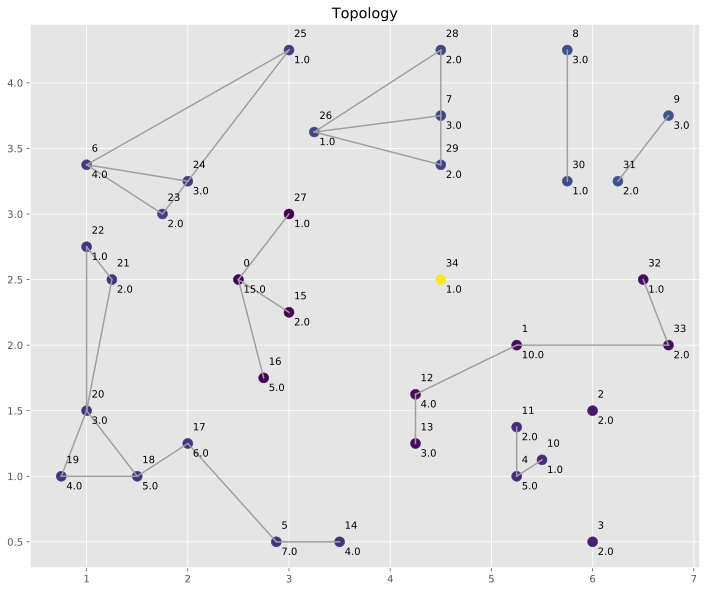

In [7]:
separate_subclasses(g)
test.display_info(plot=True)

In [8]:
for i in g.nodes:
    print(f'{i}: {g.nodes[i].subclass_id}')
    
for i in g.nodes:
    print(f'{i}: {g.neighbors.get(i, set())}')

g.edges

0: 0
1: 1
2: 2
3: 3
4: 4
5: 5
6: 6
7: 7
8: 8
9: 9
10: 4
11: 4
12: 1
13: 1
14: 5
15: 0
16: 0
17: 5
18: 5
19: 5
20: 5
21: 5
22: 5
23: 6
24: 6
25: 6
26: 7
27: 0
28: 7
29: 7
30: 8
31: 9
32: 1
33: 1
34: 34
0: {15, 16, 27}
1: {33, 12}
2: set()
3: set()
4: {10, 11}
5: {14, 17}
6: {23, 24, 25}
7: {26, 28, 29}
8: {30}
9: {31}
10: {4}
11: {4}
12: {1, 13}
13: {12}
14: {5}
15: {0}
16: {0}
17: {18, 5}
18: {17, 19, 20}
19: {18, 20}
20: {18, 19, 21, 22}
21: {20, 22}
22: {20, 21}
23: {24, 6}
24: {25, 6, 23}
25: {6, 24}
26: {7, 28, 29}
27: {0}
28: {7, 26}
29: {7, 26}
30: {8}
31: {9}
32: {33}
33: {32, 1}
34: set()


{(0, 15): 0,
 (0, 16): 0,
 (0, 27): 0,
 (1, 12): 0,
 (1, 33): 0,
 (4, 10): 0,
 (4, 11): 0,
 (5, 14): 0,
 (5, 17): 0,
 (6, 23): 0,
 (6, 24): 0,
 (6, 25): 0,
 (7, 26): 0,
 (7, 28): 0,
 (7, 29): 0,
 (8, 30): 0,
 (9, 31): 0,
 (12, 13): 0,
 (17, 18): 0,
 (18, 19): 0,
 (18, 20): 0,
 (19, 20): 0,
 (20, 21): 0,
 (20, 22): 0,
 (21, 22): 0,
 (23, 24): 0,
 (24, 25): 0,
 (26, 28): 0,
 (26, 29): 0,
 (32, 33): 0}